In [1]:
from sklearn.svm import SVC
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ml_utils
import geopandas as gpd
#import geoplot
from shapely.geometry import Point

# Spatial Data Crash Course

We can use spatial data to do fun map-type stuff, and even use it to make some models. This is a quick intro, you'll probably need to read some documentation to do your project stuff, but this will get you started. 

### Geopandas and Spatial Data

Geopandas is a library that we can use to make spatial things easier. It is basically pandas, with a few special things added to deal with spatial data. So we'll load our data into a Geopandas dataframe instead of a normal one, it is tailored to make using spatial data easier. Our spatial data has a few features that are important and different from normal data:

<ul>
<li> <b>Geometry</b> - this is the "spatial thing" that makes map stuff work. Geometry is the mapping bit of the data. There are a couple of types that we will use:
    <ul>
    <li> <b>Polygon/multipolygon</b> - this is a shape - a neighborhood, country, region, etc... This is basically a definition of the outline of something on a map. 
    <li> <b>Point</b> - a latitude and longitude spot on a map. 
    <li> <b>Line</b> - points that are connected, like a bus route. (We won't use this one here)
    </ul>
<li> <b>Plot</b> - we can just ask a geopandas dataframe to plot and it will draw its geometry for us. 
<li> <b>Sjoin</b> - this will join based on spatial data as the criteria. This is how geopandas can do things like tell us "is this point in this area".
<li> <b>Distance</b> - we can ask for the distance between two points, or the distance between a point and a region. Geopandas will do the math for us, including the "fact" that the earth is curved. 
</ul>

![Spatial Data](images/spatial_data.png "Spatial Data")

Otherwise, a geopandas dataframe does all the same stuff as a normal one. 

## Important Spatial Bits

For the most part, our use of spatial data won't be that complex or confusing. We do need to be comfortable with a couple of concpets though.

<b>Note:</b> analyzing spatial data is a very large and complex field, and there's lots of other stuff you could do. We're slicing off a little bit so we can use position in our modelling. 

### Spatial, the Final Frontier

Our spatial data deals with positions on a map - the planet. We can think of the world as a giant 2D scatter plot, where the x and y axes are latitude and longitude. The one wrinkle in here is that the earth, unless you're Kyrie, is curved - for the most part, the spatial tools that we'll use are built to handle that without much manual intervention from us. 

![Kyrie](images/kyrie.png "Kyrie")

Every point on the eart is obviously also defined by the latitude and longitude, which can position it precicely on the map. Lastly, we need to think of regions or areas, like countries, provinces, cities, or neighborhoods. These regions are defined by their boundaries, so they are basically a shape with a precicely defined and specifically located boundary. For example, Alberta doesn't exist in any sense other than the boundaries that are defined for it - that "geometry" is an outline of exactly where that border is in lat/long space on our plane. 

### Spatial Files 

Many datasets have latitude and longitude for specific points, the geometry of regions is found in spatial files. The ones we have here are shapefiles (shp), but there are others (kml and others). We can usually download these by just Googling and finding one. The most common use case I can think of is that you'll start with some data that has lat/lon locations; you then download a spatial file that defines regions like neighborhoods, countries, etc... You can connect these two to say things like incident X happened in neighborhood Y. 

These files are normally listings of areas (neighborhoods, countries, etc...) and their geometry, or their "outlines". The geometry part isn't really something we'd look at outside of it being mapped. 

## MN Use of Force

First example - can we figure out if neighborhood demographics is a predictor of police use of force in Minneapolis. We will start by loading a file with the uses of force, complete with the latitude and longitude of each incident. Our spatial use will be to identify which neighborhood the incident happened in, by using the point location of the incident along with the geographical boundaries of each neighborhood, to determine where each thing happened.

<b>Note:</b> This has the neighborhood info in it. We are going to ignore it to use spatial stuff later on. 

In [2]:
uof = gpd.read_file('data/mn_spatial/Police_Use_of_Force-shp/Police_Use_of_Force.shp', geometry = "geometry")
uof = uof[uof["CenterLong"]<-90]
uof.head()

,PoliceUseO,CaseNumber,ResponseDa,Problem,Is911Call,PrimaryOff,SubjectInj,ForceRepor,SubjectRol,SubjectR_1,...,TotalPreci,TotalNeigh,CenterGBSI,CenterLati,CenterLong,CenterX,CenterY,DateAdded,OBJECTID,geometry
0,11104226,08-003786,2008-01-04,Suspicious Vehicle,Yes,FLEE,Yes,2,A,1.0,...,84018.0,1927,20947,44.898115,-93.225106,-1.037777e+07,5.605496e+06,2020-05-28,1,POINT (-93.22511 44.89812)
1,11104227,08-007154,2008-01-07,Suspicious Person,No,LOITER,No,1,A,1.0,...,46998.0,23458,25860,44.979240,-93.278939,-1.038376e+07,5.618254e+06,2020-05-28,2,POINT (-93.27894 44.97924)
2,11104228,08-018973,2008-01-19,Suspicious Vehicle,No,RECVEH,No,2,A,2.0,...,80434.0,13679,18761,45.010118,-93.286438,-1.038460e+07,5.623115e+06,2020-05-28,3,POINT (-93.28644 45.01012)
3,11104229,08-025734,2008-01-27,Neighbor Trouble,Yes,OBSTRU,Yes,1,A,1.0,...,80434.0,13679,25902,45.013029,-93.290726,-1.038508e+07,5.623573e+06,2020-05-28,4,POINT (-93.29073 45.01303)
4,11104230,08-030812,2008-02-01,Attempt Pick-Up,No,WT,None,2,A,2.0,...,80434.0,15344,19606,45.003397,-93.303748,-1.038653e+07,5.622056e+06,2020-05-28,5,POINT (-93.30375 45.00340)


In [3]:
uof.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PoliceUseO,28704.0,NaN,NaN,NaN,11118672.534211,8318.006697,11104226.0,11111482.75,11118677.5,11125875.25,11133137.0
CaseNumber,28704,12362,14-289909,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ResponseDa,28704,4094,2014-08-17,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Problem,28623,125,Suspicious Person,4852,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Is911Call,28704,2,No,16074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PrimaryOff,28703,204,OBSTRU,5060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SubjectInj,19305,2,No,9664,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ForceRepor,28704.0,NaN,NaN,NaN,1.525746,0.991568,1.0,1.0,1.0,2.0,19.0
SubjectRol,28694,36,A,19510,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SubjectR_1,28694.0,NaN,NaN,NaN,1.194501,0.702185,0.0,1.0,1.0,1.0,18.0


### Look at Distribution by 'Hood

We are going to reconstruct this with a spatial join, but we should expect our numbers to be similar later on. 

In [4]:
uof.groupby("Neighborho").agg("count").sort_values("CaseNumber", ascending=False)

,PoliceUseO,CaseNumber,ResponseDa,Problem,Is911Call,PrimaryOff,SubjectInj,ForceRepor,SubjectRol,SubjectR_1,...,TotalPreci,TotalNeigh,CenterGBSI,CenterLati,CenterLong,CenterX,CenterY,DateAdded,OBJECTID,geometry
Neighborho,,,,,,,,,,,,,,,,,,,,,
Downtown West,7656,7656,7656,7646,7656,7656,4036,7656,7656,7656,...,7656,7656,7656,7656,7656,7656,7656,7656,7656,7656
Jordan,1415,1415,1415,1414,1415,1415,1139,1415,1415,1415,...,1415,1415,1415,1415,1415,1415,1415,1415,1415,1415
Hawthorne,1288,1288,1288,1286,1288,1288,939,1288,1288,1288,...,1288,1288,1288,1288,1288,1288,1288,1288,1288,1288
Near - North,1259,1259,1259,1258,1259,1259,984,1259,1259,1259,...,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259
Willard - Hay,972,972,972,972,972,972,779,972,972,972,...,972,972,972,972,972,972,972,972,972,972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hale,23,23,23,23,23,23,19,23,23,23,...,23,23,23,23,23,23,23,23,23,23
Camden Industrial,14,14,14,14,14,14,13,14,14,14,...,14,14,14,14,14,14,14,14,14,14
Page,14,14,14,14,14,14,12,14,14,14,...,14,14,14,14,14,14,14,14,14,14


#### Drop the 'Hoods

We are going to figure out the hood using spatial data, so we can drop it here. 

In [5]:
uof.drop(columns={"Neighborho"}, inplace=True)

### Load Spatial File that Maps the City

This file is a shapefile that has the geometry of the city of Minneapolis. We can use this to map the city, and then plot our data on top of it.

In [6]:
city = gpd.read_file("data/mn_spatial/City_Boundary-shp/mn_city_boundary.shp")
city.head()

,OBJECTID,NAME,Shape__Are,Shape__Len,geometry
0,1,Minneapolis,2.971535e+08,86299.67181,"POLYGON ((-93.32911 44.91972, -93.32909 44.925..."


In [7]:
#CSV version of use of force data - used in testing to create this file. 
#force_list = pd.read_csv("data/mn_spatial/Police_Use_of_Force.csv")
#force_list = force_list[force_list["X"]<-90]
#force_list.head()

### Load Spatial File that Maps the 'Hoods

This file is a shapefile that has the geometry of all of the neighborhoods in Minneapolis. We can use this break the city up into neighborhoods, and then plot our data on top of it.

In [8]:
hoods = gpd.read_file("data/mn_spatial/Minneapolis_Neighborhoods/Minneapolis_Neighborhoods.shp")
hoods.head()

,OBJECTID,INT_REFNO,PREFIX,UDI,SYMBOL_NAM,BDNAME,BDNUM,TEXT_NBR,SHAPE_Leng,SHAPE_Area,geometry
0,1,-2.144135e+09,REFNO,23152.00,WARDAREA,Phillips West,90,90,0.045801,0.000113,"POLYGON ((-93.26258 44.96091, -93.26258 44.960..."
1,2,-2.144131e+09,REFNO,23187.00,WARDAREA,Downtown West,87,87,0.063671,0.000220,"POLYGON ((-93.26011 44.98300, -93.26010 44.982..."
2,3,-2.144131e+09,REFNO,23188.00,WARDAREA,Downtown East,88,88,0.045179,0.000109,"POLYGON ((-93.24499 44.97893, -93.24499 44.978..."
3,4,0.000000e+00,REFNO,23189.00,WARDAREA,Ventura Village,89,89,0.059590,0.000134,"POLYGON ((-93.24958 44.96630, -93.24951 44.966..."
4,5,-2.144137e+09,REFNO,23129.00,WARDAREA,Sumner - Glenwood,29,29,0.035535,0.000061,"POLYGON ((-93.28830 44.98904, -93.28830 44.989..."


### Load Excel File that has Demographics by 'Hood

We'll join this to the use of force data above to create our data for predictions - can we predict the use of force by neighborhood demographics? 

In [9]:
hood_demo = pd.read_excel("data/mn_spatial/hood_demo.xlsx")
hood_demo.head()

,Neighborhood,Total population,Total population - Share - Margin of Error,Total population - Share,Total population - Margin of Error,Male,Male - Share - Margin of Error,Male - Share,Male - Margin of Error,Female,...,Poverty 35-44 - Share,Poverty 35-44 - Margin of Error,Poverty 45-54,Poverty 45-54 - Share - Margin of Error,Poverty 45-54 - Share,Poverty 45-54 - Margin of Error,Poverty 55-64,Poverty 55-64 - Share - Margin of Error,Poverty 55-64 - Share,Poverty 55-64 - Margin of Error
0,Wenonah,4736,394,1,0.0832,2369,229,0.5003,0.0483,2367,...,0.0766,0.0812,784,512.0,0.1662,0.1084,821,749,0.1739,0.1587
1,St. Anthony East,2049,178,1,0.0869,1104,123,0.5388,0.0600,945,...,0.1394,0.1453,646,590.0,0.3153,0.2881,1108,356,0.5407,0.1737
2,Lyndale,7078,505,1,0.0714,3452,369,0.4877,0.0521,3626,...,0.1403,0.0825,1852,1029.0,0.266,0.1478,1471,956,0.2113,0.1372
3,Downtown East,1925,238,1,0.1235,1074,160,0.5578,0.0830,851,...,0.1717,0.2397,268,339.0,0.1622,0.2054,301,284,0.1821,0.1719
4,Tangletown,4605,230,1,0.0499,2197,219,0.4771,0.0475,2408,...,0.0522,0.0714,78,184.0,0.0172,0.0408,47,123,0.0103,0.0273


#### Interlude - Where Are We Now?

Right now our data is split up in a bunch of different dataframes:
<ul>
<li> <b>use_of_force</b> - the details of where each use of force happened, with the latitude and longitude of each incident.
<li> <b>hoods</b> - the geometry of each neighborhood.
<li> <b>city</b> - the geometry of the city of Minneapolis. This is basically just our background. 
<li> <b>demographics</b> - the demographics details of each neighborhood.
</ul>

To make our feature set, we need to do some joining of the datasets, then construct some data. The hoods and demographics datasets can be connected with a simple join - when the neighborhood names are equal. These are connected to the use of force data with a spatial join - we'll use the geometry of the hoods and the location of the incidents to determine which neighborhood each use of force incident happened in.

### Join the demographics data with the neighborhood map. 

Our use of force data has 'hoods, and the demographics data has 'hoods. Join on that value to combine the two. 

<b>The positive impact of this is that we are effectively adding the spatial info for each hood to the demographics data.</b>

<b>Note:</b> if we end up with blanks later on it is probably due to small spelling issues (e.g. dashes, capitalization, spaces, etc...) between the neighborhoods in either table. We'd want to correct this by manually checking those that don't match and correcting the spelling. For example, the neighborhood "St. Anthony East" might be "Saint Anthony East" or similar. I don't really want to do that 50 times for this, if it was a real project we would do so. If the data was clean the join would be "perfect" - there'd be one row per hood for use of force, one row per hood for demographics. 

In [10]:
hood_full = pd.merge(hoods, hood_demo, how='inner', left_on = 'BDNAME', right_on = 'Neighborhood')
hood_full.head()

,OBJECTID,INT_REFNO,PREFIX,UDI,SYMBOL_NAM,BDNAME,BDNUM,TEXT_NBR,SHAPE_Leng,SHAPE_Area,...,Poverty 35-44 - Share,Poverty 35-44 - Margin of Error,Poverty 45-54,Poverty 45-54 - Share - Margin of Error,Poverty 45-54 - Share,Poverty 45-54 - Margin of Error,Poverty 55-64,Poverty 55-64 - Share - Margin of Error,Poverty 55-64 - Share,Poverty 55-64 - Margin of Error
0,1,-2.144135e+09,REFNO,23152.00,WARDAREA,Phillips West,90,90,0.045801,0.000113,...,0.3939,0.1972,2387,1055.0,0.4556,0.2014,1872,783,0.3575,0.1495
1,2,-2.144131e+09,REFNO,23187.00,WARDAREA,Downtown West,87,87,0.063671,0.000220,...,0.205,0.1148,2437,751.0,0.319,0.0983,2013,761,0.2635,0.0996
2,3,-2.144131e+09,REFNO,23188.00,WARDAREA,Downtown East,88,88,0.045179,0.000109,...,0.1717,0.2397,268,339.0,0.1622,0.2054,301,284,0.1821,0.1719
3,4,0.000000e+00,REFNO,23189.00,WARDAREA,Ventura Village,89,89,0.059590,0.000134,...,0.3983,0.1026,3121,957.0,0.4789,0.1469,3687,842,0.5658,0.1292
4,6,-2.144140e+09,REFNO,23101.00,WARDAREA,Shingle Creek,1,01,0.055048,0.000147,...,0.0912,0.0621,190,161.0,0.0584,0.0494,628,477,0.1932,0.1467


### Plot the Data we Have

We can plot some stuff, in 3 layers:
<ol>
<li> Plot the outline of the city. Geometry = city outlines. 
<li> Plot the outlines of the 'hoods, from the new dataframe we just joined. Geometry = 'hood outlines. 
<li> Plot the uses of force. Geometry = the lat/lon point where it occured.
</ol>

<Axes: >

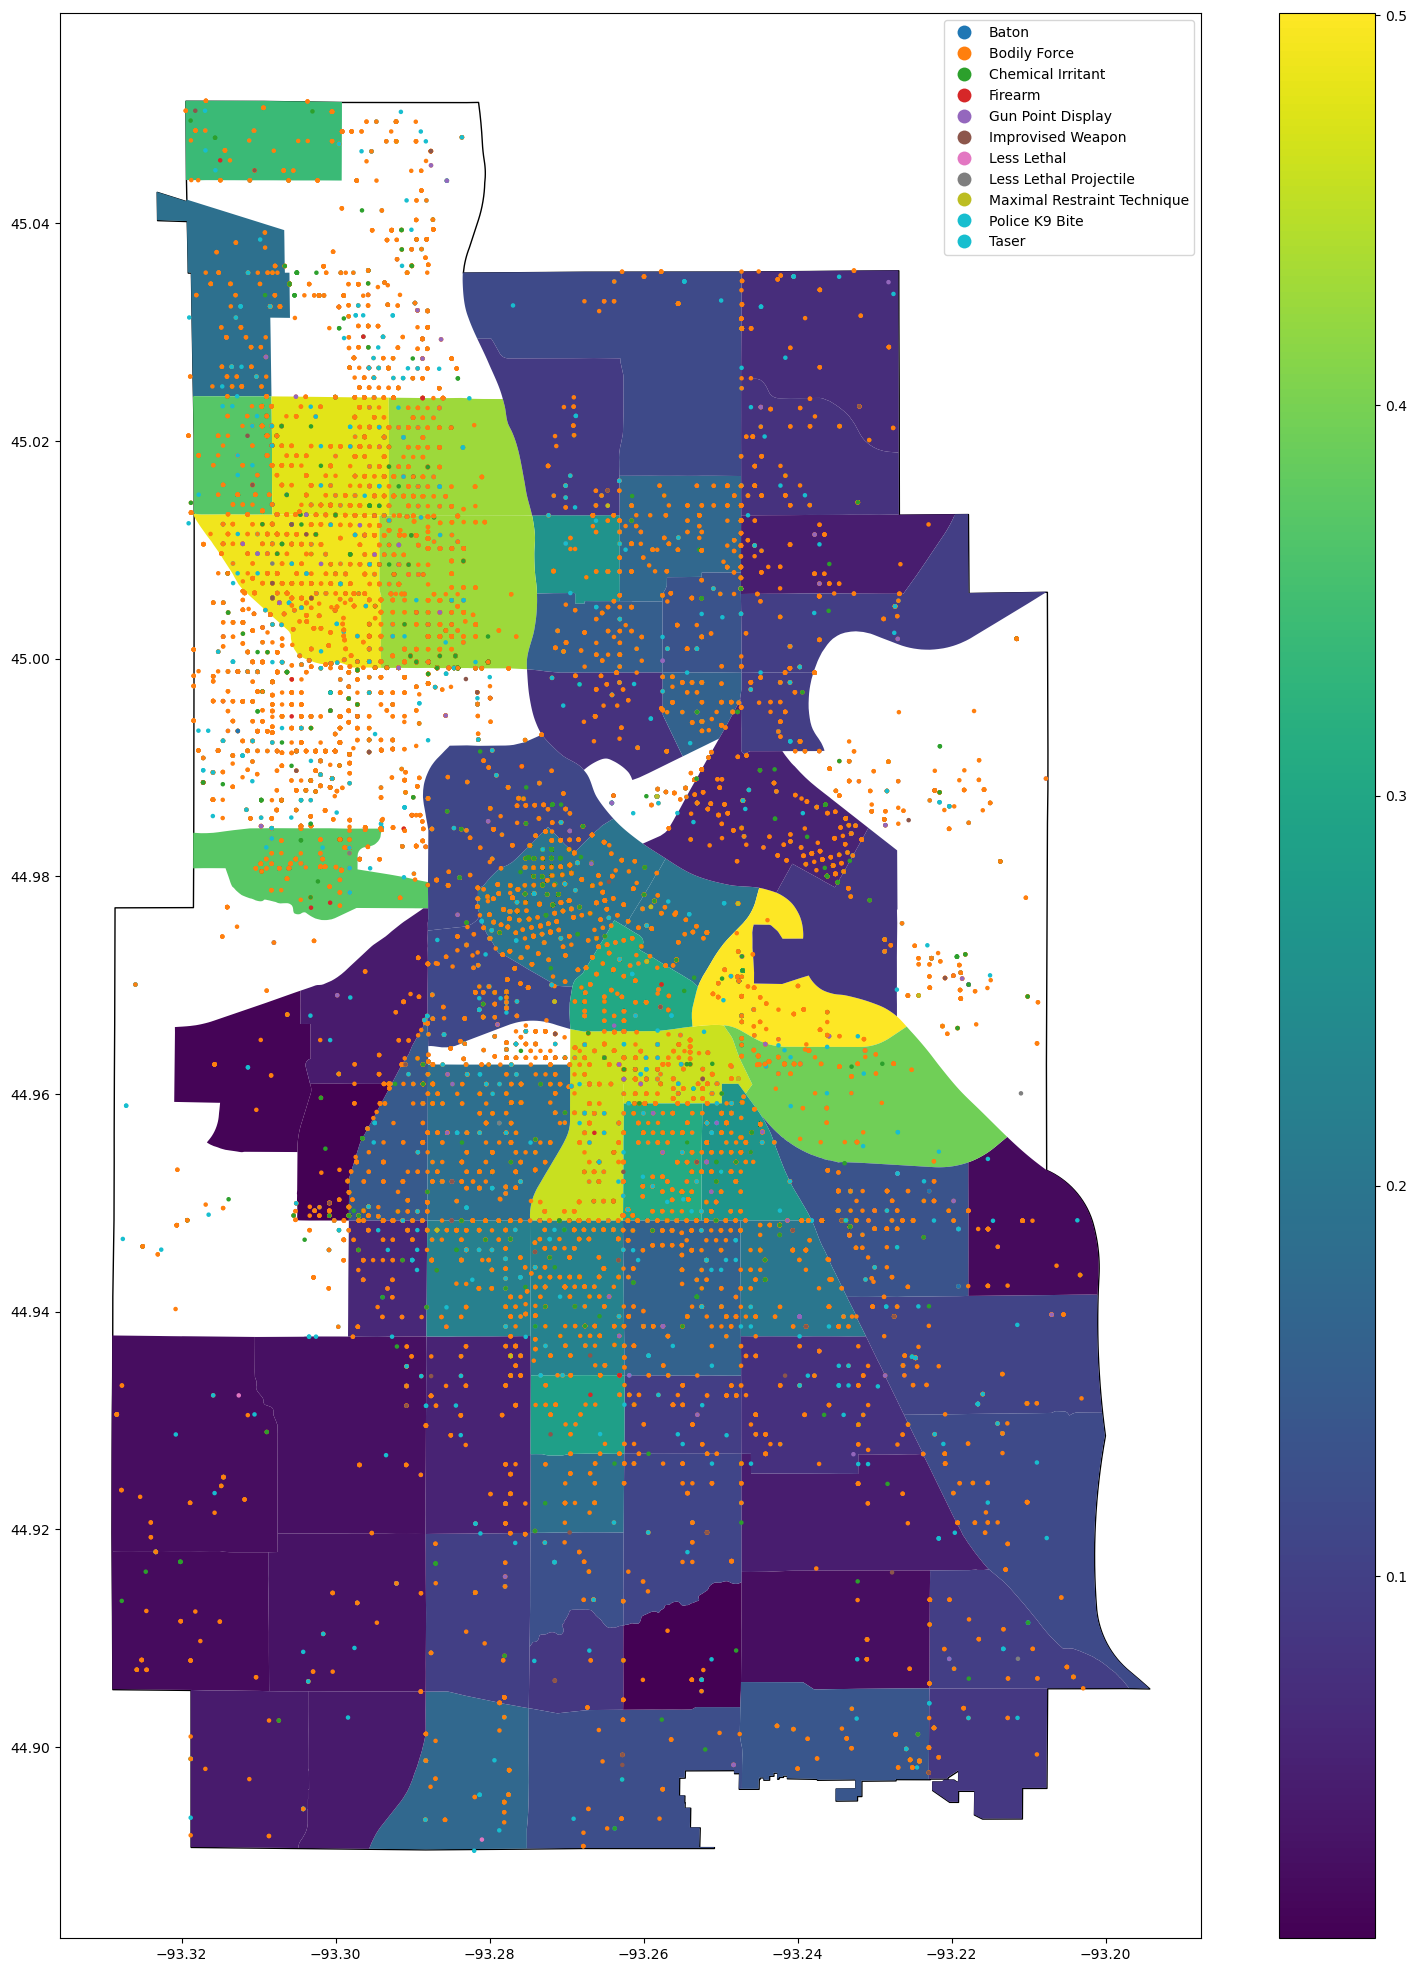

In [11]:
base = city.plot(color='white', edgecolor='black', figsize=(20,25))
hood_full.plot(ax=base, column="Black or African American - Share", legend=True)
uof.plot(ax=base, marker='o', column="ForceType", categorical=True, markersize=5, legend=True)

### Generate Prediction Data

Ok, we can try to predict some stuff now.... 

Our target will be the count of uses of force in a 'hood, from the use of force dataframe. Our inputs will be a few pieces of demographic data, from the joined dataframe we just made. We will combine the two by doing a spatial join - we'll ask geopandas to use "is this point (a use of force) in this polygon (the boundaries of a 'hood) as the join criteria. 

We don't have a lot of rows here as input data, so we shouldn't expect to have great models. Cleaning up the data to get all the 'hoods would help a little. We're here for the geography though, not the accuracy - the concepts are identical if we had more data

Note: We had 'hoods in the use of force data, so we could construct this without the geopandas stuff at all. We're doing this as though we had the lat/lon of force, and the spatial data separate. This process makes it pretty generalizable - as long as we have the lat/lon of a "thing" and a shapefile of the regions, we can connect the two. 

### Pick Some Features

Choose different ones if you want. Our number of rows is low, so using lots of features will tend towards overfitting. 

If this was a real project, you'd want to do some EDA here to figure out what might really matter, and maybe do some transformations like PCA or normalize uses of force by population. We're skipping that stuff. 

In [12]:
features = ["Black or African American - Share", "American Indian and Alaska Native - Share", "Asian or Pacific Islander - Share",
            "Other race - Share", "Two or more races - Share", "Hispanic or Latino - Share", "Foreign born - Share", "Language other than English - Share",
            "Owner-occupied - Share", "Median household income (2008-2012, 2012 dollars)", "Less than $35,000 - Share", "CaseNumber"]

### Where Da Hood At? - Do Spatial Join

![Where Da Hood At?](images/where_hood.jpeg "Where Da Hood At?")

The sjoin is a geopandas special, a spatial join. We specify "within" as the criteria so it automagically knows to figure out if the points for use of force are in the polygons of the 'hoods. Super easy! If we relate it back to our "the world is a scatter plot" analogy, geopanda's join condition is that the X/Y (lat/lon) of the point is within the boundaries of the neighborhood shapes.

Then we do some aggregation to count the number of uses of force; the max is to get the demographics data - those values are always the same for each 'hood, so this is a quick way to just keep that value. 

<b>Note:</b> This leaves us with 2 column header rows, one for the feature, and one for the aggregation; this is called a multiindex. These are kind of annoying to deal with, we remove it by just ditching what we don't want and renaming the columns to our feature list. 

In [13]:
force_in_hood = uof.sjoin(hood_full, how="left", predicate="within")
counts = force_in_hood.groupby('BDNAME').agg(['count','max'])
counts.reset_index(inplace=True, col_fill="BDNAME")

/var/folders/p1/m8wtcgx57417hx9d_r110ctw0000gn/T/ipykernel_48176/3301191244.py:2: FutureWarning: ['Problem', 'PrimaryOff', 'SubjectInj', 'SubjectRol', 'ForceType', 'ForceTypeA', 'TypeOfResi', 'geometry'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  counts = force_in_hood.groupby('BDNAME').agg(['count','max'])


In [14]:
#Clean Dataframe to prep for predictions. 
hood_count = counts[features]

hood_count = hood_count.iloc[:,[1,3,5,7,9,11,13,15,17,19,21,22]]
hood_count.columns = features
hood_count.sort_values("CaseNumber", ascending=False)

,Black or African American - Share,American Indian and Alaska Native - Share,Asian or Pacific Islander - Share,Other race - Share,Two or more races - Share,Hispanic or Latino - Share,Foreign born - Share,Language other than English - Share,Owner-occupied - Share,"Median household income (2008-2012, 2012 dollars)","Less than $35,000 - Share",CaseNumber
14,0.1962,0.0205,0.1035,0.0016,0.0364,0.0486,0.1977,0.1865,0.2699,50796.0,0.2750,7817
25,0.4284,0.0288,0.2212,Suppressed,0.0583,0.0760,0.2004,0.3896,0.3035,43698.0,0.5268,1491
29,0.4904,0.0034,0.1436,0.0039,0.0651,0.1502,0.2281,0.3760,0.4299,43477.0,0.4397,1423
64,0.4613,0.0538,0.0272,0.0013,0.0392,0.2167,0.4230,0.5867,0.1082,25364.0,0.6304,865
21,0.4790,0.0052,0.1505,Suppressed,0.0470,0.0484,0.0819,0.1680,0.4736,43247.0,0.3263,827
...,...,...,...,...,...,...,...,...,...,...,...,...
32,0.0122,0.0023,0.0506,Suppressed,0.0046,0.0124,0.0671,0.0746,0.4656,115000.0,0.1563,24
0,0.0422,Suppressed,0.0556,Suppressed,0.0366,0.0431,0.0884,0.0981,0.8650,140363.0,0.1274,23
23,0.0087,0.0462,0.0059,Suppressed,0.0424,0.0227,0.0256,0.0428,0.9268,130313.0,0.0960,22
51,0.0847,0.0061,0.0152,0.0107,0.0094,0.0131,0.0576,0.0896,0.9012,132731.0,0.0793,15


### Outliers in Target

We have one hood that has LOTS of uses of force, and a few with lots. These massive outliers will probably screw with modelling, so we'll filter it out. In real life (i.e. gov't policy), you'd probably want to investigate thest individually - they are probably some downtown area that has lots of traffic, business, bars, congregations, etc... and generate outsized numbers of police interactions. Domain knowledge type of deal - it may make sense to examine residental 'hoods and central business areas somewhat differently in a situation like this. 

This also might be a case where binning the target and doing a classification may make sense - e.g. 'hoods of low violence, medium, high, etc... 

In [15]:
hood_count = hood_count[hood_count["CaseNumber"] < 1000]

### Preview the Data via Pariplot

Just for fun! I'm going to look specifically if there appears to be a relationship between the # of cases and any of the inputs. 

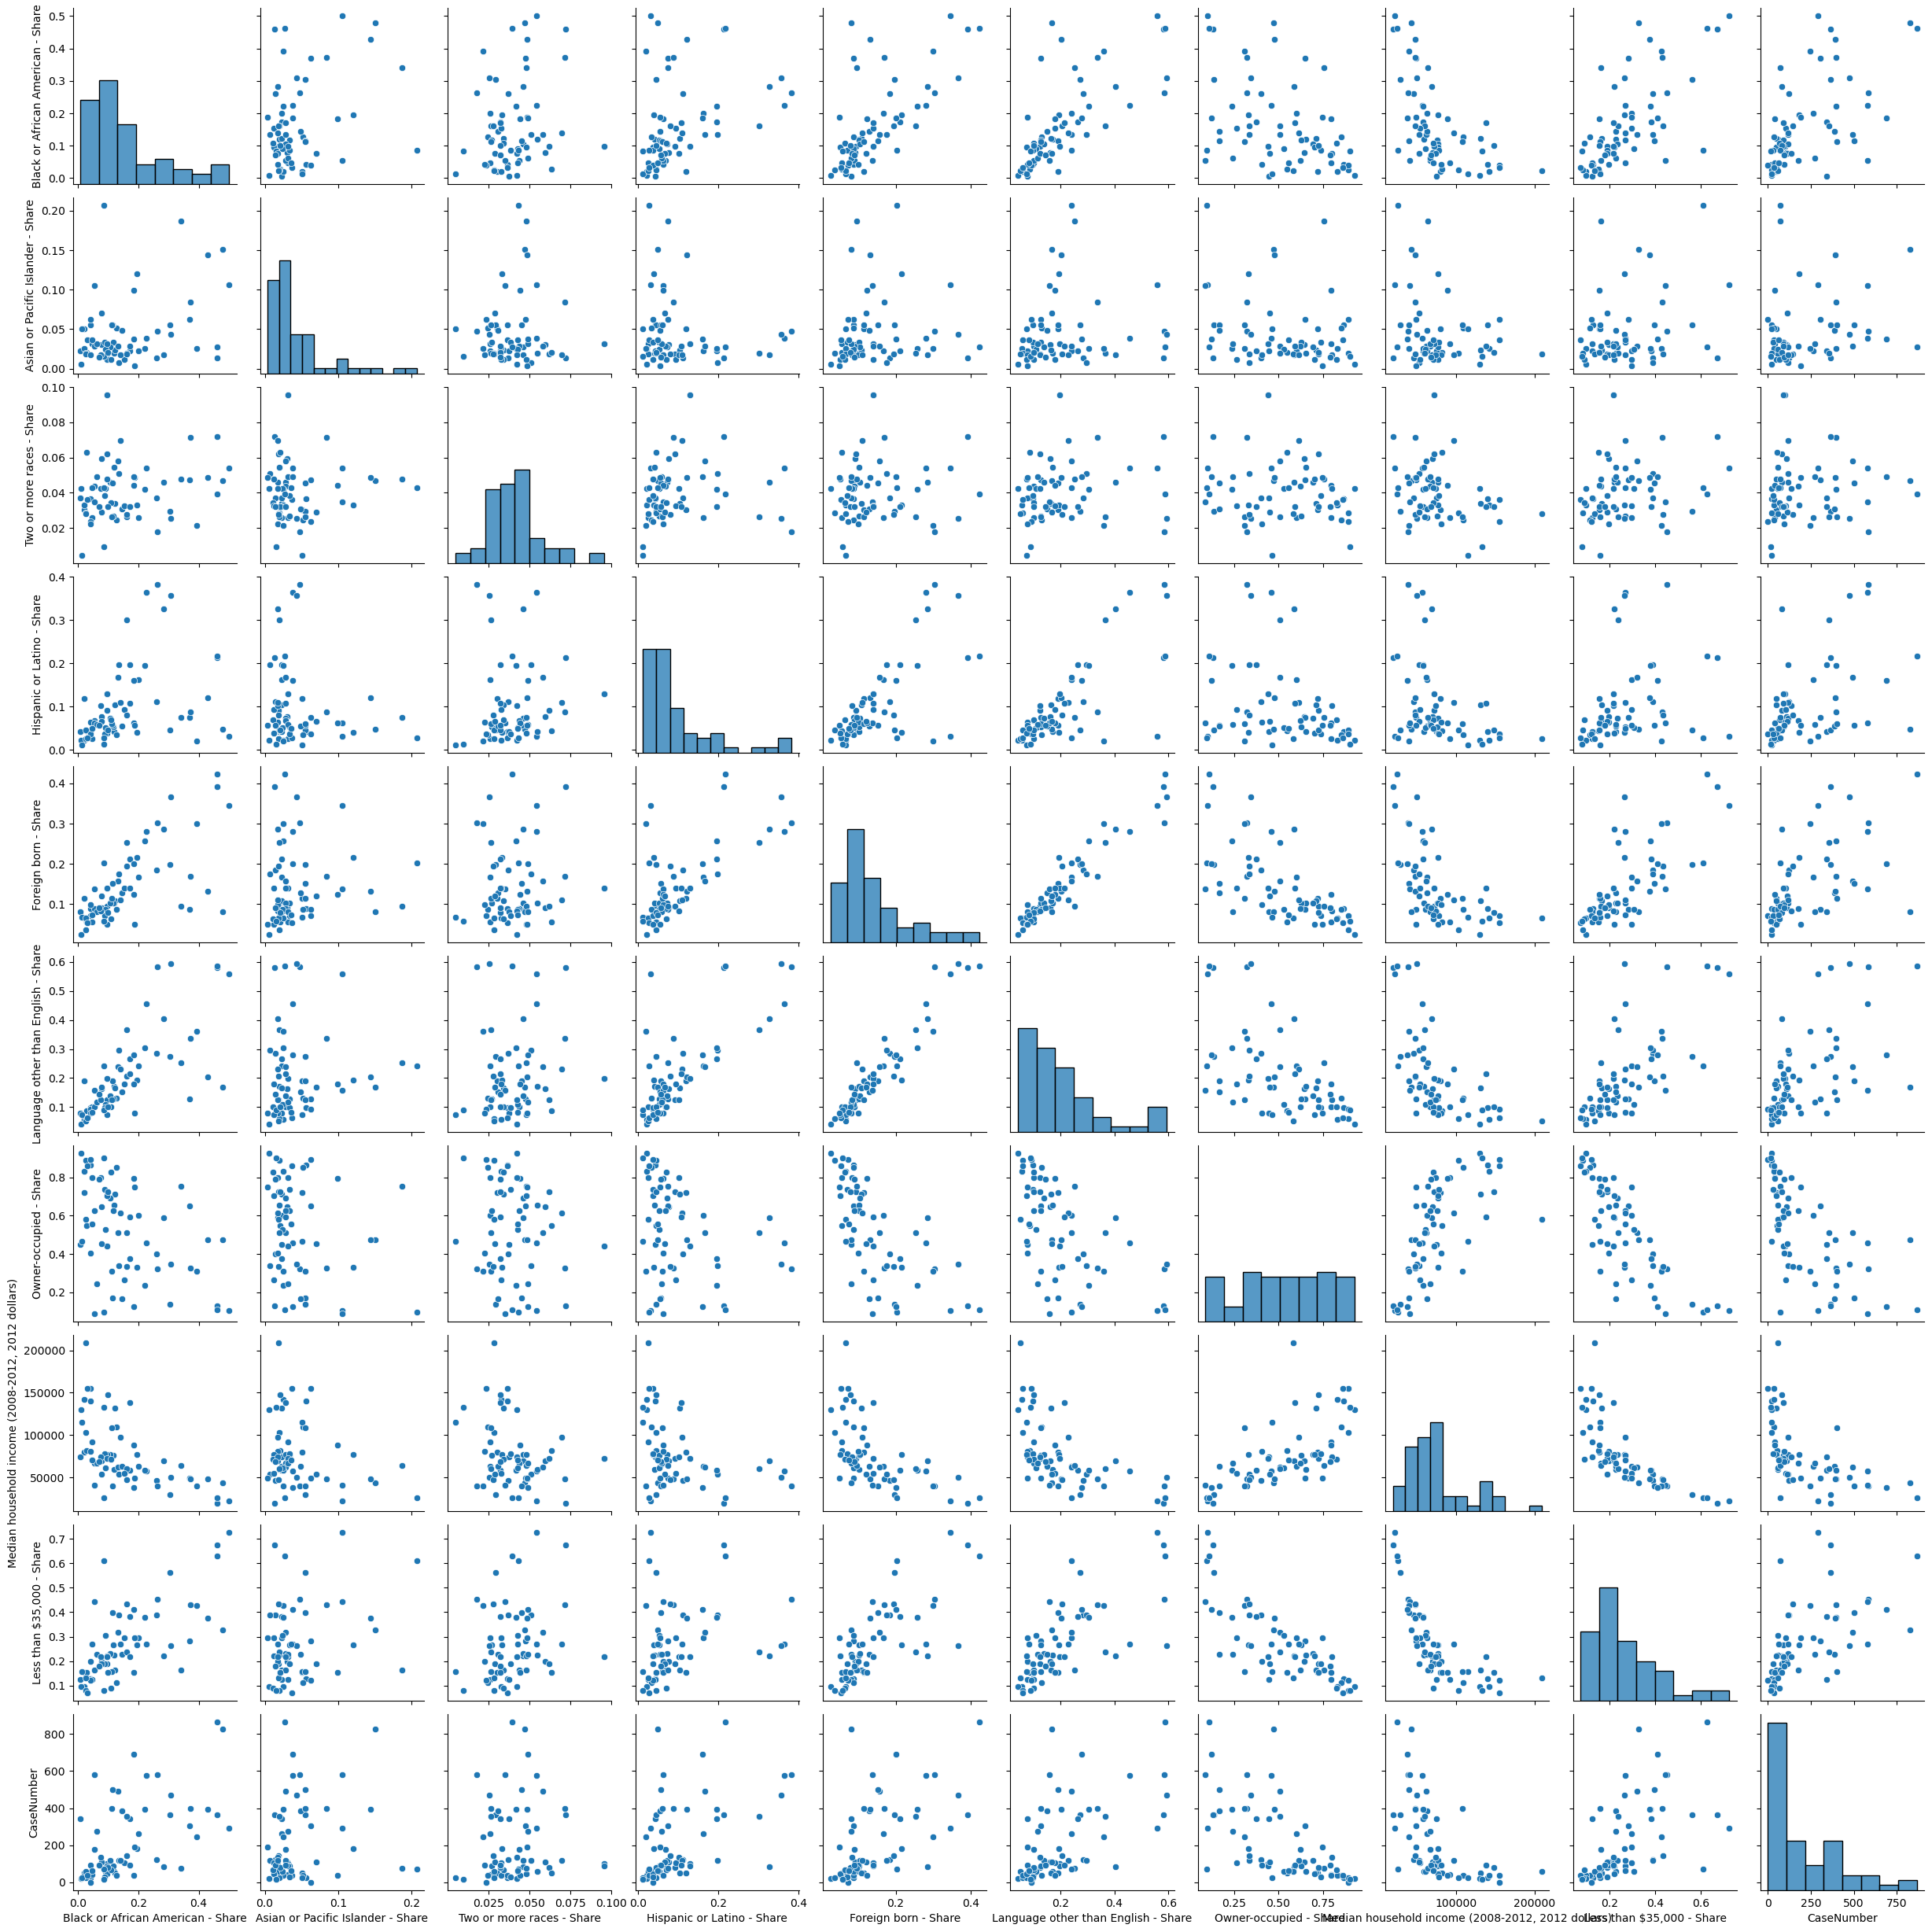

In [16]:
sns.pairplot(hood_count)

In [17]:
#check for nan values - this will matter for imputation in a minute
hood_count.isna().sum()

Black or African American - Share                    0
American Indian and Alaska Native - Share            0
Asian or Pacific Islander - Share                    0
Other race - Share                                   0
Two or more races - Share                            0
Hispanic or Latino - Share                           0
Foreign born - Share                                 0
Language other than English - Share                  0
Owner-occupied - Share                               0
Median household income (2008-2012, 2012 dollars)    0
Less than $35,000 - Share                            0
CaseNumber                                           0
dtype: int64

In [18]:
# Prepare feature and target sets. 
y = hood_count["CaseNumber"]
X = hood_count.drop(columns={"CaseNumber"})
X.shape, y.shape

((68, 11), (68,))

### OK, Time to Model

I'm not really doing much here to drive accuracy, you'd probably want to try a few models and do a grid search. In reality, you'd probably want to start with lots of demographic features and aggressively feature select or dimension reduce down to what matters. You'd also start with some specific premise with this type of question, e.g. "how do economic factors impact police uses of force" that would guide you. We're doing this for the love of the spatial, so we can assume that all the other model tuning stuff we've covered could be applied here.

The imputation is set to replace "Suppressed" with 0. This is a domain knowledge thing - as far as I can tell when they are doing surveys of demographic info, when the absolute count is too low, the results are not published (Suppressed), to ensure that things are not able to be tied to specifc individuals. This type of thing is common with reporting survey info. 0 may or may not be the best choice, I honestly don't have the knowledge on this topic to really know for sure. 

<b>Note:</b> We should not expect great results here - there is very little data! We're doing this for the spatial aspects! Seriously, the results will not be very reliable here. 

In [19]:
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

impute = SimpleImputer(missing_values="Suppressed", strategy="constant", fill_value=0)
scaler = MinMaxScaler()
#model = SGDRegressor(max_iter=10000)
#model = Lasso(max_iter=10000, alpha=.01)
model = RandomForestRegressor()

X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y)

pipeline_steps = [("impute", impute),
                ("scale", scaler),
                ("model", model) ]
pipe = Pipeline(pipeline_steps)
pipef = pipe.fit(X_train_, y_train_)
print("Simple Score (R2):", pipef.score(X_test_,y_test_))
print("CV Scores (RMSE):\n", cross_val_score(pipe, X, y, cv=10, scoring="neg_root_mean_squared_error")*-1)
print("CV Scores (R2):\n", cross_val_score(pipe, X, y, cv=10, scoring="r2"))

Simple Score (R2): 0.3868972122554145
CV Scores (RMSE):
 [172.29360617 118.28820311 225.43360597  51.09133181 141.32368509
 114.7378972  116.78435976 126.55667783 289.28370595 146.14038891]
CV Scores (R2):
 [-4.0385348   0.57627055  0.30260747  0.89169396  0.46795058  0.61570492
  0.57763346 -0.00928326 -0.10345081  0.5572071 ]


### Results

We have predictions! Not really awesome ones, but predictions none the less. To make this better, we prep data better. Clean 'hoods data so they are all included. EDA and feature select demographic data better. Incorporate domain knowledge to treat the areas of the city properly - residential vs commerical vs industrial, population density, etc... 

We can also see from the randomness of the results from the cross validation scores that we are not getting a great model overall. 

## You Know Nothing Jon Snow!

![Jon Snow](images/jon_snow.jpg "Jon Snow")

This example was real - Jon Snow saved London from Cholera way back in the day. In short, London had outbreaks of cholera and no one really knew why because germ theory was not really a thing. Our intrepid young crow stupidly ditched Yvette in that cave and attempted to solve this mystery with science, data science! He figured out that the water from the pumps was contaminated, and that the water from the wells was not. He was able to convince the city to switch to well water, and the cholera outbreak stopped. Mr. You Know Nothing did this by plotting where people died, where water pumps were, and where they got their water from.

<b>tl;dr the water from pumps was contaminated from things like diaper juice draining into drinking water. </b>

<b>Note:</b> this example is not a super strong predictive model, it is more to play with the GIS data. Our sample size is small, likely too small to make a great predictive model. In a larger example we could apply the same concepts and get a stronger R2 from the resulting model, this one is more of a fun toy. This one is also limited by the fact that everyone needs water, even if they don't live right by a pump, so distance is, at best, a weak predictor. 

### Read Datasets of Death Locations and Pump Locations

We have two datasets, both giving us specific lat/lon locations. One is the locations of deaths from cholera, the other is the locations of the pumps that were used to distribute water.

In [29]:
deaths_df = gpd.read_file('data/SnowGIS/Cholera_Deaths.shp')
pumps_df = gpd.read_file('data/SnowGIS/Pumps.shp')

### Translate the X and Y Values into Lat/Lon

<b>Note:</b> You may ask, "can't we just use the points directly?" The answer is yes, but geopandas has recently gotten a little more strict with something called a coordinate system, which is basically a standard for encoding data. You can impose the coordinate systems on the data, and do things directly from the points, but this way is generic and will always work, so we'll do it the dummy way. 

In [30]:
deaths_df["lon"] = deaths_df.geometry.x
deaths_df["lat"] = deaths_df.geometry.y
deaths_df.head()

,Id,Count,geometry,lon,lat
0,0,3,POINT (529308.741 181031.352),529308.741420,181031.351546
1,0,2,POINT (529312.164 181025.172),529312.163571,181025.172401
2,0,1,POINT (529314.382 181020.294),529314.382429,181020.293688
3,0,1,POINT (529317.380 181014.259),529317.379645,181014.258771
4,0,4,POINT (529320.675 181007.872),529320.675449,181007.871628


In [31]:
# To Edit
pumps_df["lon"] = pumps_df.geometry.x/100000
pumps_df["lat"] = pumps_df.geometry.y/100000
pumps_df["geometry"] = gpd.points_from_xy(pumps_df["lon"], pumps_df["lat"])
pumps_df.head()

,Id,geometry,lon,lat
0,0,POINT (5.294 1.810),5.293965,1.810251
1,0,POINT (5.292 1.811),5.291925,1.810794
2,0,POINT (5.292 1.812),5.291837,1.811937
3,0,POINT (5.297 1.809),5.297489,1.809242
4,0,POINT (5.296 1.809),5.296132,1.808968


### Calculate Distance Between Deaths and Pumps

Loop through the data and calculate how far each death location is from each pump. Geopandas does this magically - if we have two points it will figure out distance for us. Cool! This is a big part of the magic of geopandas, and an example of how it deals with the "round" earth myth that is plaguing society. Calculating the distance between 2 points on a flat plane is easy, calculating that distance when both points are on a sphere is more complex. Gepandas abstracts out that complexity, so we just get distance.

We are left with a list of places, containing their location, a count of deaths, and the distance from each water pump. 

In [32]:
i = 0
dist_cols = []
for index, row in pumps_df.iterrows():
    pump = row["geometry"]
    #pump_geo = row["geometry"]
    #print(pump_geo)
    col_name = "pump_"+str(i)
    dist_cols.append(col_name)
    deaths_df[col_name] = deaths_df["geometry"].distance(pump)
    #print(row["geometry"], i)
    i += 1
deaths_df.head()

,Id,Count,geometry,lon,lat,pump_0,pump_1,pump_2,pump_3,pump_4,pump_5,pump_6,pump_7
0,0,3,POINT (529308.741 181031.352),529308.741420,181031.351546,559404.892997,559404.894752,559404.894465,559404.889989,559404.891362,559404.893100,559404.892311,559404.894692
1,0,2,POINT (529312.164 181025.172),529312.163571,181025.172401,559406.131408,559406.133162,559406.132875,559406.128400,559406.129772,559406.131511,559406.130722,559406.133103
2,0,1,POINT (529314.382 181020.294),529314.382429,181020.293688,559406.652156,559406.653911,559406.653624,559406.649149,559406.650521,559406.652260,559406.651470,559406.653852
3,0,1,POINT (529317.380 181014.259),529317.379645,181014.258771,559407.535314,559407.537068,559407.536781,559407.532306,559407.533678,559407.535417,559407.534628,559407.537009
4,0,4,POINT (529320.675 181007.872),529320.675449,181007.871628,559408.587108,559408.588863,559408.588576,559408.584100,559408.585473,559408.587211,559408.586422,559408.588803


### Feature Construction - Distance to The Closest Pump

The latitudes and longitudes don't really make good features to generate predictive models, so we need to construct some! Look at all the distances to pumps, and find the smallest. Plug this into a new feature. Do the same for the mean distance. 

We are constructing the feature set that we'll use for modelling here, which is something that is reasonably common in the real world. In short, we want to transform what we have, a bunch of locations, into something that we can use to make a model. The "closest pump" is a decision that we made as analysts, under the assumption that the closest pump is the one most used by the people who died. There may be other reasonable, or even better, ways we could construct these features - we could have the average of the 3 closest, or we could take the 4 smallest distances, etc... This is a domain knowledge thing, if we were doing this in reality we'd probably at least have access to someone with an idea on where people got their water in real life, so we could base our simplification on that. In reality, the closest distance likely isn't the best choice - try to play with a few other features that you can construct to see if things look more predictive. 

In [33]:
deaths_df["min_dist"] = deaths_df[[c for c in deaths_df.columns if c in dist_cols]].min(axis=1)
deaths_df["avg_dist"] = deaths_df[[c for c in deaths_df.columns if c in dist_cols]].mean(axis=1)
deaths_df.head()

,Id,Count,geometry,lon,lat,pump_0,pump_1,pump_2,pump_3,pump_4,pump_5,pump_6,pump_7,min_dist,avg_dist
0,0,3,POINT (529308.741 181031.352),529308.741420,181031.351546,559404.892997,559404.894752,559404.894465,559404.889989,559404.891362,559404.893100,559404.892311,559404.894692,559404.889989,559404.892959
1,0,2,POINT (529312.164 181025.172),529312.163571,181025.172401,559406.131408,559406.133162,559406.132875,559406.128400,559406.129772,559406.131511,559406.130722,559406.133103,559406.128400,559406.131369
2,0,1,POINT (529314.382 181020.294),529314.382429,181020.293688,559406.652156,559406.653911,559406.653624,559406.649149,559406.650521,559406.652260,559406.651470,559406.653852,559406.649149,559406.652118
3,0,1,POINT (529317.380 181014.259),529317.379645,181014.258771,559407.535314,559407.537068,559407.536781,559407.532306,559407.533678,559407.535417,559407.534628,559407.537009,559407.532306,559407.535275
4,0,4,POINT (529320.675 181007.872),529320.675449,181007.871628,559408.587108,559408.588863,559408.588576,559408.584100,559408.585473,559408.587211,559408.586422,559408.588803,559408.584100,559408.587070


### Check Distance vs Deaths

We can plot visually to see if there's any obvious relationship. We'll plot both the minimum and average distances. 

<Axes: xlabel='min_dist', ylabel='Count'>

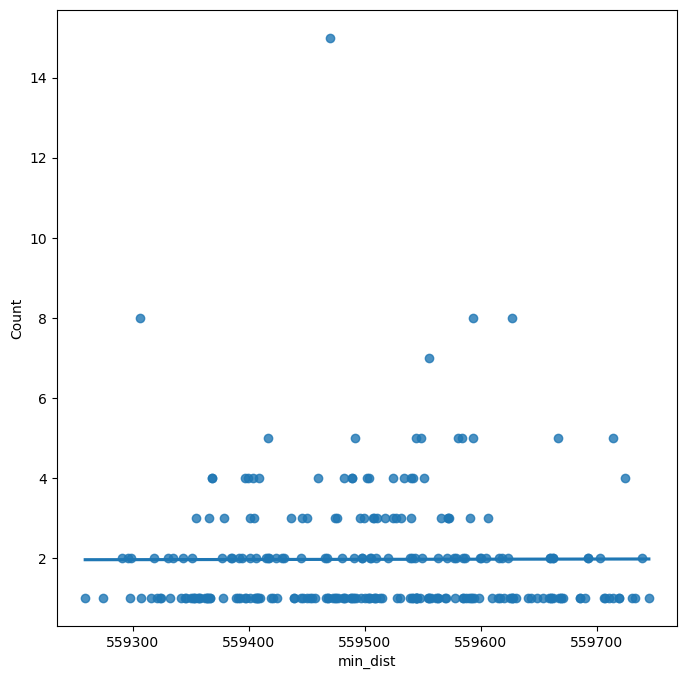

In [34]:
sns.regplot(data=deaths_df, x="min_dist", y="Count", ci=0)

<Axes: xlabel='avg_dist', ylabel='Count'>

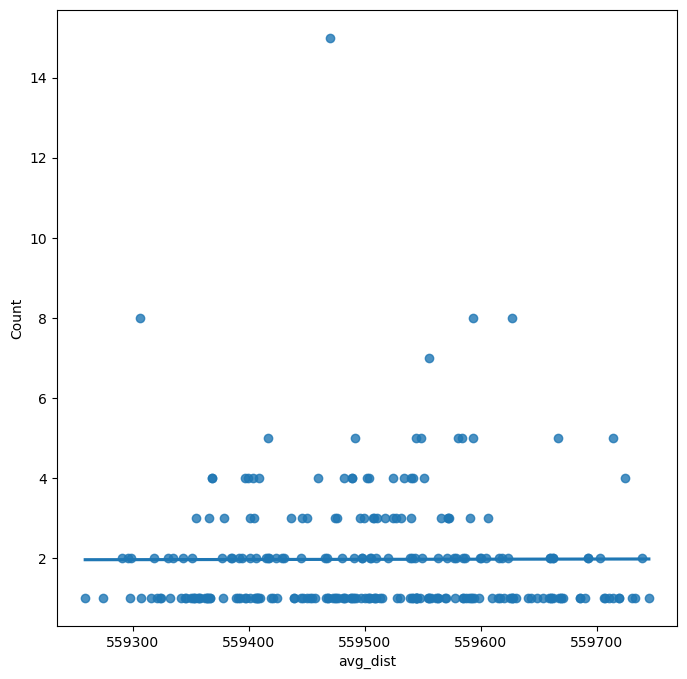

In [35]:
sns.regplot(data=deaths_df, x="avg_dist", y="Count", ci=0)

### Plot the Map

Challenge - find a shapefile for this part of London, map that with the points. I couldn't find one, which was somewhat surprising, so I'm just going to plot the points. In general these things are usually pretty easy to find through searching. 

The pumps are red X's, the deaths are dots.

<Axes: >

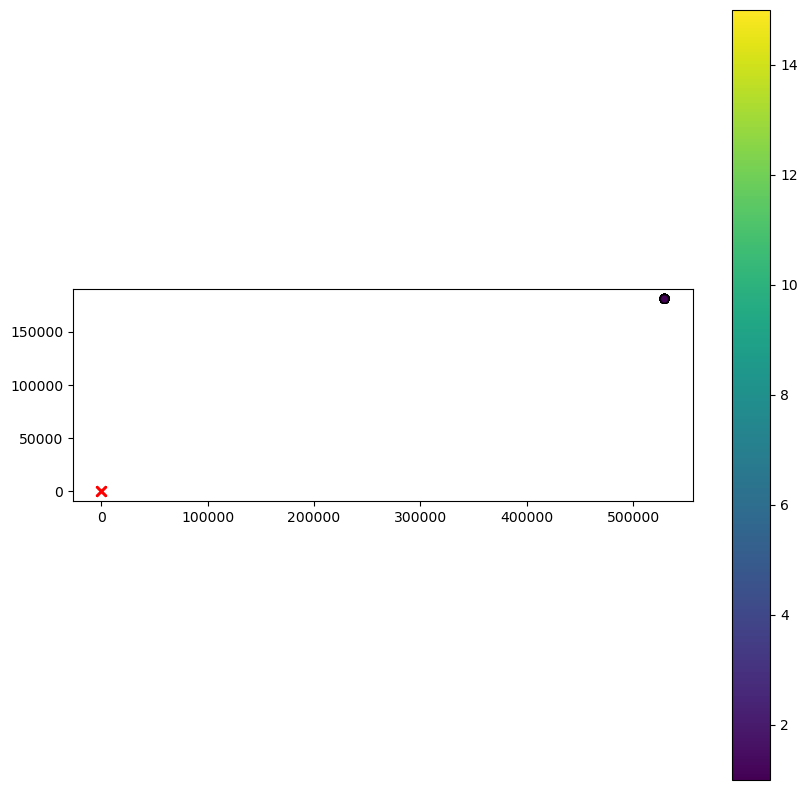

In [36]:
#Plot 
ax = deaths_df.plot(column='Count', figsize=(10, 10), alpha=0.5, edgecolor='k', legend=True)
pumps_df.plot(ax=ax, marker='x', color='red', markersize=50)

### Model to Predict

We can create a predictive model - it is likely more useful for this one to just do a simple linear regression of dist vs death, but we're here to model!!

Again, limited data -> very random changes with different splits of train/test. 

<b>Bonus Fun Fact:</b> There was a brewery right in the middle of the map, and employees of said brewery didn't die from cholera; they were given free beer and thus were safe, though they were at risk of stumbling off course when trying to walk-of-shame themselves home. 

In [37]:
from sklearn.linear_model import LinearRegression
model2 = LinearRegression()
scale2 = MinMaxScaler()

y2 = np.array(deaths_df["Count"]).reshape(-1,1)
X2 = np.array(deaths_df[["min_dist" ,"avg_dist"]])

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3)

pipeline_steps2 = [("scale", scale2),
                ("model", model2)]
pipe2 = Pipeline(pipeline_steps2)
pipe2.fit(X_train2, y_train2.ravel())

print(pipe2.score(X_test2, y_test2.ravel()))


-0.01671379525963168
